### Import Libraries

In [48]:
import nltk
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC # SVM
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier # MLP Classifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer # Sentence Transformer
from sklearn.feature_extraction.text import CountVectorizer

## Read dataset

In [49]:
df = pd.read_csv('Dataset/implicit_hate_v1_stg1_posts.tsv', sep='\t')
# Five random samples of the dataset
df.sample(5)

,post,class
18741,i'm not a racist but this the very first time ...,not_hate
9209,white power company : power to our people via,implicit_hate
18960,the point is that white people say that black ...,not_hate
8160,the protesters in new mexico were thugs who we...,implicit_hate
7009,indians are pre colombians . white people foun...,implicit_hate


In [50]:
# Shape of Data Frames
print('No of records:', df.shape[0])
print('No of columns:', df.shape[1])

No of records: 21480
No of columns: 2


post     0
class    0
dtype: int64


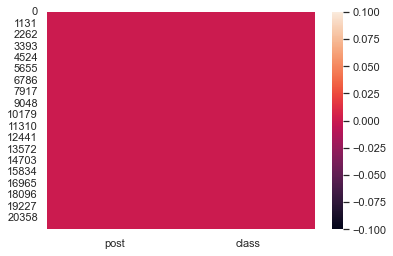

In [51]:
# Null values in columns:
sns.heatmap(df.isna())
print(df.isna().sum())

it shows that the data is already clean.

### Data Preprocessing

In [52]:
def preprocess(data):
    # Lowercase conversion
    data['post'] = data['post'].apply(
        lambda x: " ".join(x.lower() for x in x.split()))
    # Removal of special characters
    data['post']= data['post'].str.replace('[^\w\s]', ' ')
    # Removal of Digits & numbers
    data['post'] = data['post'].str.replace('\d+',' ')
    data['post'] = data['post'].str.replace('_',' ')
    # Removal of stopwords
    data['post'] = data['post'].apply( 
        lambda x: " ".join(x for x in x.split() if x not in stopwords.words('english')))
    # Lemmatization
    data['post'] = [WordNetLemmatizer().lemmatize(word) for word in data['post']]
    
    return data

df_preprocess = preprocess(df)

### Data Visualization

<AxesSubplot:xlabel='class', ylabel='count'>

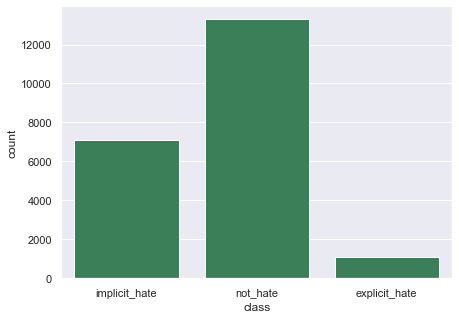

In [53]:
plt.figure(figsize=(7, 5))
sns.set()
sns.countplot(df['class'], color='seagreen')

### Data Encoding

In [54]:
df_preprocess['class'] = df_preprocess['class'].replace({'implicit_hate': 'hate', 'explicit_hate': 'hate'})
df_preprocess['class'] = df_preprocess['class'].replace({'not_hate': 0, 'hate': 1})

## Binary Classification (baseline)

In [55]:
# Feature and target selection
X = df_preprocess['post']
y = df_preprocess['class']

In [157]:
# Load pre-trained BERT model
model_name = 'bert-base-nli-mean-tokens'
model = SentenceTransformer(model_name)

# Encode text using pre-trained BERT model
encoded_text = model.encode(X.tolist())

### Data Balancing

In [158]:
from imblearn.over_sampling import RandomOverSampler
# Define the undersampling method
oversampler = RandomOverSampler()
# # Undersample the data
x_sampled, y_sampled = oversampler.fit_resample(encoded_text, y)

print('No. of samples(not_hate):', y.value_counts()[0])
print('No. of samples(hate):', y.value_counts()[1])
print('\nAfter Balancing data----------------------------')
print('\nNo. of samples(not_hate):', y_sampled.value_counts()[0])
print('No. of samples(hate):', y_sampled.value_counts()[0])

No. of samples(not_hate): 13291
No. of samples(hate): 8189

After Balancing data----------------------------

No. of samples(not_hate): 13291
No. of samples(hate): 13291


#### Data splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_sampled, y_sampled, 
                                                    test_size=0.2, random_state=42)

### MLP Classifier

Accuracy: 0.7936806469813805 

              precision    recall  f1-score   support

    not_hate       0.82      0.76      0.79      2702
        hate       0.77      0.83      0.80      2615

    accuracy                           0.79      5317
   macro avg       0.80      0.79      0.79      5317
weighted avg       0.80      0.79      0.79      5317



<AxesSubplot:>

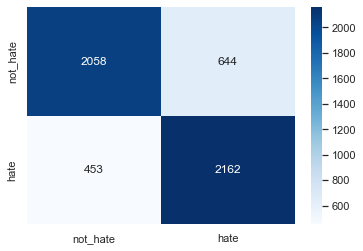

In [160]:
# Define MLP classifier with 6 output classes
classifier = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=1000)

# Train the classifier on the encoded text
classifier.fit(X_train, y_train)

# Predict the labels for the encoded text
y_pred = classifier.predict(X_test)

# Calculate accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy} \n")

# Calculate classification report and confusion matrix
classes = ['not_hate', 'hate']
print(classification_report(y_test, y_pred, target_names= classes))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes, fmt='d')

# Binary Classification (CountVectorizer)

In [56]:
vectorizer = CountVectorizer(max_features=1000) 
x = vectorizer.fit_transform(df_preprocess['post']).toarray()

In [57]:
y = df_preprocess['class']

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, random_state=42)

### Deep Neural Network + Random Forest Classifier

In [59]:
# deep learning model initialization
model = tf.keras.models.Sequential()  
model.add(Dense(1000,input_shape=(1000,),activation='relu'))
model.add(Dense(500,activation='relu'))
model.add(Dense(300,activation='relu'))
model.add(Dense(150,activation='relu'))
model.add(Dense(75,activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dropout(0.5))

x_train_1 = model.predict(x_train)
x_test_1 = model.predict(x_test)

# Random Forest
clf = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=42)
clf = clf.fit(x_train_1, y_train)
rf_pred = clf.predict(x_test_1)
print('\033[47m' + 'Classification Report\n\n' + '\033[0m' + '\033[34m', classification_report(y_test, rf_pred))

135/135 [==============================] - 2s 11ms/step
Classification Report

               precision    recall  f1-score   support

           0       0.63      0.94      0.76      2674
           1       0.50      0.10      0.16      1622

    accuracy                           0.62      4296
   macro avg       0.57      0.52      0.46      4296
weighted avg       0.58      0.62      0.53      4296



### Deep Neural Network + Support Vector Classifier

In [60]:
# deep learning model initialization
model = tf.keras.models.Sequential()  
model.add(Dense(1000,input_shape=(1000,),activation='relu'))
model.add(Dense(300,activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dropout(0.5))

x_train_2 = model.predict(x_train)
x_test_2 = model.predict(x_test)

# SVM
svc_model = SVC()
svc_model.fit(x_train_2, y_train)
svc_pred = svc_model.predict(x_test_2)
print('\033[47m' + 'Classification Report\n\n' + '\033[0m' + '\033[32m', classification_report(y_test, svc_pred))

135/135 [==============================] - 1s 9ms/step
Classification Report

               precision    recall  f1-score   support

           0       0.64      0.95      0.76      2674
           1       0.54      0.11      0.18      1622

    accuracy                           0.63      4296
   macro avg       0.59      0.53      0.47      4296
weighted avg       0.60      0.63      0.54      4296

